# Boosting族算法

Boosting 是一族将弱学习器提升为强学习器的算法。这族算法的工作机制类似：
1. 先从初始训练集 $D_1$ 训练出一个基学习器 $h_1$;
2. 再根据基学习器 $h_1$ 的表现对训练样本分布进行调整（方式可以为对样本进行加权或者重采样），得到调整后的样本分布 $D_2$;
3. 基于 $D_2$ 重新来训练下一个基学习器 $h_2$；
4. 重复步骤1-3 直到基学习器数目达到事先指定的T，最终将这T个基学习器进行加权结合。

Boosting族算法中最著名的代表就是 **AdaBoost(Adaptive Boosting的缩写) 和 梯度提升(Gradient Boosting)。**

## AdaBoost

###  AdaBoost 的理论推导

给定已标记数据集 $D = \{ (\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), ... , (\mathbf{x}_n, y_n)\},$ 其中 $ \mathbf{x}_i = (x_{i1}, x_{i2}, ...,x_{id}), y_i\in \{-1, +1\}$,假设 f 是真实函数。我们的模型为：

$$ H(\mathbf{x}) = \sum_{t=1}^{T}\alpha_t h_t (\mathbf{x})$$

我们将最小化指数损失函数作为我们的优化目标：

$$\ell_{exp}(H|D) = \mathbf{E}_{\mathbf{x}\backsim D}[e^{-f(\mathbf{x})H(\mathbf{x})}]$$

下面我们首先来说明**为什么我们选择指数损失函数来作为0/1损失函数的替代函数。**

若 $H(\mathbf{x})$ 能令指数损失函数最小化，我们考虑上式对 $H(\mathbf{x})$ 求偏导。

假设 $g(f(\mathbf{x})) = e^{-f(\mathbf{x})H(\mathbf{x})}$，则有

$$\mathbf{E}[g(\mathbf{x})] = \sum_{x \backsim D}g(\mathbf{x})P_{\mathbf{X}}(\mathbf{x})$$

所以

$$\ell_{exp}(H|D) = \mathbf{E}(g(f(\mathbf{x}))) =  \sum_{y_i \backsim \{-1, +1\}} g(f(\mathbf{x}))P(f(\mathbf{x}) = y_i)$$

对 H 求偏导，有

$$\begin{split}
\frac{\partial \ell_{exp}(H|D)}{\partial H(\mathbf{x})} &= \sum_{y_i \backsim \{-1, +1\}} \frac{\partial g(f(\mathbf{x}))}{\partial H(\mathbf{x})}P(f(\mathbf{x}) = y_i)\\
&=\sum_{y_i \backsim \{-1, +1\}} -f(\mathbf{x})  e^{-f(\mathbf{x})H(\mathbf{x})} P(f(\mathbf{x}) = y_i)\\
&= -  e^{-H(\mathbf{x})} P(f(\mathbf{x}) = 1) + e^{H(\mathbf{x})} P(f(\mathbf{x}) = -1)
\end{split}$$

令上式为0，可得

$$ H(\mathbf{x})  = \frac{1}{2}\ln \frac{P(f(\mathbf{x}) = 1)}{P(f(\mathbf{x}) = -1)} $$

因此有

$$\begin{split}
sign (H(\mathbf{x})) &= sign\left(\frac{1}{2}\ln \frac{P(f(\mathbf{x}) = 1)}{P(f(\mathbf{x}) = -1)}\right)\\
&=\arg\max_{y\in\{-1, +1\}}P(f(\mathbf{x}) = y)
\end{split}$$

这意味着 $sign(H(\mathbf{x}))$ 达到了贝叶斯最优错误率。换句话说，<span class="girk">指数损失函数最小化，则分类错误率也将最小化</span>，<span class="girk">说明指数损失函数是分类任</span><span class="girk">务原本0/1损失函数的一致的替代损失函数</span>。另外，这个替代函数有更好的数学性质，所以用它来作为替代损失函数。

在 AdaBoost 算法中，每次迭代中需要求解的更新包括了系数$\alpha_t$ 以及分布$D_t$ 的更新，即训练集里每个样本的权重的更新。下面我们就来推导两者的更新公式。

**STEP1 $\alpha_t$的更新**

第一个基分类器 $h_1$ 是通过直接将基学习算法应用于初始数据分布而得（对应的每个样本的权重一致）；此后迭代生成 $h_t$、$\alpha_t$，当基分类器 $h_t$ 应用于分布 $D_t$ 产生后，该基分类器的权重 $\alpha_t$ 应使得 $\alpha_t h_t$ 最小化指数函数损失：

$$\begin{split}
\ell_{exp}(\alpha_t h_t|D_t) &= \mathbf{E}_{\mathbf{x}\backsim D_t}\left[e^{-f(\mathbf{x})\alpha_t h_t(\mathbf{x})}\right]\\
&= \mathbf{E}_{\mathbf{x}\backsim D_t}\left[e^{-\alpha_t}(f(\mathbf{x})= h_t(\mathbf{x}))^{bool} + e^{\alpha_t}(f(\mathbf{x})\neq h(\mathbf{x}))^{bool} \right]\\
&= e^{-\alpha_t}P_{\mathbf{x}\backsim D_t}(f(\mathbf{x})= h_t(\mathbf{x})) + e^{\alpha_t}P_{\mathbf{x}\backsim D_t}(f(\mathbf{x})\neq h_t(\mathbf{x}))\\
&=e^{-\alpha_t}(1-\epsilon_t) + e^{\alpha_t}\epsilon_t
\end{split}$$

其中 $\epsilon_t = P_{\mathbf{x}\backsim D_t}(f(\mathbf{x})\neq h_t(\mathbf{x})),\; (\bullet)^{bool}$ 表示指示函数，为真时取值为1，为假时取值为0。

假设 在第 t 轮训练中，训练样本 $\mathbf{x}_i^t \in D_t$ 对应的权重为$w_i^t$，则基学习器 $ h_t(\mathbf{x})$ 对应的误差 $\epsilon_t$为

$$\epsilon_t = \frac{\sum_{ h_t(\mathbf{x}_i^t)\neq f(\mathbf{x}_i^t)}w_i^t}{\sum_{i=1}^m w_i^t}$$

考虑指数损失函数的导数
$$\frac{\partial\ell_{exp}(\alpha_t h_t|D_t)}{\partial \alpha_t} = - e^{-\alpha_t}(1-\epsilon_t) + e^{\alpha_t}\epsilon_t$$

为零，可得

$$\alpha_t = \frac{1}{2}\ln\left( \frac{1-\epsilon_t}{\epsilon_t}\right) \tag{Alpha}$$

<span class="girk">这就是 AdaBoost 算法的系数更新公式</span>。

注1：如果记

$$\alpha_t = \eta \ln\left( \frac{1-\epsilon_t}{\epsilon_t}\right)$$

我们称 $\eta$ 为学习率，按照后面我们的样本权重更新公式，会发现错误样本迭代的关键系数是$\exp(\alpha_t)$.

$$\exp(\alpha_t) = \exp\left(\eta \ln( \frac{1-\epsilon_t}{\epsilon_t})\right)
=\left( \frac{1-\epsilon_t}{\epsilon_t}\right)^\eta$$

我们对这个指数函数进行taylor展开：
$$\exp(\alpha_t) = \left( 1 + \frac{1-\epsilon_t}{\epsilon_t} - 1\right)^\eta = 1 + \eta(\frac{1-\epsilon_t}{\epsilon_t} - 1) + o(x)$$

一般情况下 $\eta \in (0,1]$，从采样上讲相当于对错误样本整体的 $\eta$ 部分进行了权重的提升。

注2： 由 $\alpha_t$ 的公式可知，误差率 $\epsilon_t$ 越小，对应的集成学习中相应基学习器的系数越大，也就说，在AdaBoost中，让准确率更高的基学习器所起的作用越大。

**STEP2 $D_t$的更新**

AdaBoost 算法在获得 $H_{T-1}$ 之后样本分布将进行调整，使下一轮的基学习器 $h_t$ 能纠正 $H_{T-1}$ 的一些错误。理想的 $h_t$ 能纠正 $H_{T-1}$ 的全部错误，即最小化

$$\begin{split}
\ell_{exp}(H_{T-1} + h_t|D) &= \mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})\left(H_{T-1}(\mathbf{x})+ h_t(\mathbf{x})\right))]\\
&= \mathbf{E}_{\mathbf{x}\backsim D}\left[\; exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))\; exp(-f(\mathbf{x})h_t(\mathbf{x}))\right]
\end{split}$$

注意到 $f^2 = h^2 = 1$,上式可以使用 $exp(-fh)$的taylor 展开式近似为：

$$\begin{split}
\ell_{exp}(H_{T-1} + h_t|D) &\simeq \mathbf{E}_{\mathbf{x}\backsim D}\left[\exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))\; \left( 1 - f(\mathbf{x})h_t(\mathbf{x}) + \frac{(f(\mathbf{x})h_t(\mathbf{x}))^2}{2}\right)\right]\\
&= \mathbf{E}_{\mathbf{x}\backsim D}\left[\; exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))\left( 1 - f(\mathbf{x})h_t(\mathbf{x}) + \frac{1}{2}\right)\right]
\end{split}$$

于是，理想的基学习器

$$\begin{split}
h_t(\mathbf{x}) &= \arg\min_{h}\ell_{exp}(H_{T-1} + h|D) \\
&= \arg\min_{h} \mathbf{E}_{\mathbf{x}\backsim D} 
\left[
exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))
\left( 1 - f(\mathbf{x})h(\mathbf{x}) + \frac{1}{2}\right)
\right] \\
&= \arg\max_{h} \mathbf{E}_{\mathbf{x}\backsim D}\left[\; exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))f(\mathbf{x})h(\mathbf{x})\right] \\
& = \arg\max_{h} \mathbf{E}_{\mathbf{x}\backsim D}
\left[
\frac{exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))}{ \mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))]} f(\mathbf{x})h(\mathbf{x})
\right] 
\end{split}$$

注意到 $\mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))]$ 是一个常数，令$D_t$ 表示一个分布：

$$D_t(\mathbf{x}) = \frac{D(x) exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))}{ \mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))]}$$

根据数学期望的定义，等价于求解

$$\begin{split}
h_t(\mathbf{x}) & = 
\arg\max_{h} \mathbf{E}_{\mathbf{x}\backsim D}
\left[
\frac{exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))}{ \mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))]} f(\mathbf{x})h(\mathbf{x})
\right] \\
& = \arg\max_{h} \mathbf{E}_{\mathbf{x}\backsim D_t}[f(\mathbf{x})h(\mathbf{x})]
\end{split}$$

由 $f(\mathbf{x}), h(\mathbf{x})\in\{-1, +1\}$，有

$$f(\mathbf{x})h(\mathbf{x}) = 1 - 2(f(\mathbf{x})\neq h(\mathbf{x}))^{bool}$$

则理想的基学习器

$$h_t(\mathbf{x}) = \arg\min_{h} \mathbf{E}_{\mathbf{x}\backsim D_t}[\left(f(\mathbf{x})\neq h(\mathbf{x})\right)^{bool}]$$

可见，理想的基学习器 $h_t$ 将在分布 $D_t$ 下最小化分类误差。

由上面关于$D_{t}$ 的定义，可知

$$D_{t+1}(\mathbf{x}) = \frac{D(x) exp(-f(\mathbf{x})H_{T}(\mathbf{x}))}{ \mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})H_{T}(\mathbf{x}))]}$$

我们记

$$Z_t = \frac{\mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})H_{T}(\mathbf{x}))]}{\mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))]}$$

于是我们有

$$\begin{split}
\frac{D_{t+1}(\mathbf{x})}{D_t(\mathbf{x})} &= \frac{D(x) exp(-f(\mathbf{x})H_{T}(\mathbf{x}))}{ \mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})H_{T}(\mathbf{x}))]} 
\frac{ \mathbf{E}_{\mathbf{x}\backsim D}[exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))]}{D(x) exp(-f(\mathbf{x})H_{T-1}(\mathbf{x}))}\\
&=exp \left[f(\mathbf{x})(H_{T-1}(\mathbf{x}) - H_{T}(\mathbf{x}))\right]\frac{1}{Z_t}\\
&=exp(-f(\mathbf{x})\alpha h_t(\mathbf{x}))\frac{1}{Z_t}
\end{split}$$

所以我们可以得出<span class="girk">训练集的样本权重的迭代公式</span>为：

$$ D_{t+1}(\mathbf{x}) = \frac{D_t(\mathbf{x}) e^{-f(\mathbf{x})\alpha_t h_t(\mathbf{x})} }{Z_t} \tag{Sample-Weight}$$

到此，我们便可以得到如下的 AdaBoost 算法：

<img src="figure/adaboost.png" width="400" hegiht="300" align=left />

### [sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

**需要注意的参数：**
1. base_estimator：要求基学习器针对样本是可以接受权重的，具有属性 classes_ 和 n_classes_。否则需要自己重新写一个集成，可以对样本进行重新采样来给出新的样本分布；
2. learning_rate：学习率超参数(default 为1），要在 learning_rate 和 n_estimators 之间进行平衡；
3. algorithm : 可选参数是 SAMME 和 SAMME.R，支持多分类。SAMME.R要求学习器可以给出概率估计而不只是分类。

In [47]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

上面是基于200个单层决策树训练的一个AdaBoost分类器。下面我们画出集成的决策边界.

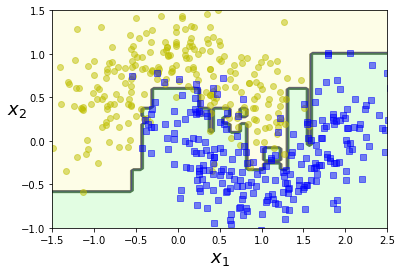

In [48]:
plot_decision_boundary(ada_clf, X, y)

下面我们以SVC为基学习器，在不同的学习率下，来看随着样本权重变化之后分类边界的变化。

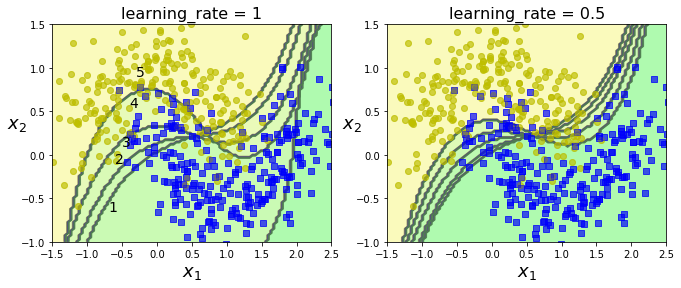

In [52]:
from sklearn.svm import SVC
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
plt.show()

## Gradient Boosting

与 AdaBoost 关注在上一轮学习中被基学习器错误分类的样本进而提升其权重、降低分类正确样本权重不同。Gredient Boosting Machine(简称 GBM)更关注截止到目前为止集成学习的错误，并对错误进行修正的一种提升方法。

下面的理论部分参考自：
1. [Greedy Function Approximation: A Gradient Boosting Machine](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)
2. [GBM Paper Reading](http://xtf615.com/paper/GBM.html)

### 基本思想

在梯度下降法中，针对成本函数 $J(\theta)$，求解$\theta^{\ast} = \arg\min_{\theta}J(\theta)$ 的梯度下降法公式为：

$$\theta_{j+1} = \theta_j - \alpha_{j+1} \frac{\partial J(\theta)}{\partial \theta}|_{\theta = \theta_j}$$

我们将上面对最佳参数的估计问题推广到函数空间对最佳逼近函数的估计问题。求解最佳逼近函数也是一个寻优过程，只是我们寻找的是最优函数估计，而不是最优点估计。

给定数据集 $D = \{ (\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), ... , (\mathbf{x}_N, y_N)\},$ 其中 $ \mathbf{x}_i = (x_{i1}, x_{i2}, ...,x_{id})$,优化目标通常为：

$$F^{\ast}(\mathbf{x}) = \arg\min_{F(\mathbf{x})}\sum_{i=1}^N L(y_i, F(\mathbf{x}_i))$$

我们把 $F(\mathbf{x})$ 视为参数 $\theta$，则有

$$F_{j+1}(\mathbf{x}) = F_j(\mathbf{x}) - \rho_{j+1} \frac{\partial L}{\partial F(\mathbf{x}) }|_{F = F_j}$$

其中$\rho_{j+1}$ 对应的是这一轮的学习率。

如果我们记

$$g_j = \frac{\partial L}{\partial F(\mathbf{x}) }|_{F = F_j} \quad and \quad f_{j+1} = -\rho_{j+1}g_j \;(j\geq 0) \quad and \quad F_0 = f_0$$

迭代次数为 m 时对应的集成

$$\begin{split}
F_m &= F_{m-1}- \rho_m g_{m-1}\\
&= \sum_{i=0}^{m-1}f_i + f_m \\
&= \sum_{i=0}^{m}f_i
\end{split}$$

所以，我们的目标就是求解如下的一个集成学习模型：

$$F^\ast(\mathbf{x}) = \sum_{i=0}^{M}f_i(\mathbf{x})$$

其中每一轮的基学习器$f_i(\mathbf{x})$ 学习的是截止到上一轮结束整个集成 $F_{m-1}(\mathbf{x})$的损失函数的梯度。

### GBM 求解过程

函数估计的目标是得到$F^{\ast}(\mathbf{x})$，在所有训练样本的联合分布上，最小化期望损失函数

$$F^{\ast}(\mathbf{x}) = \arg\min_{F}E_{y,\mathbf{x}}L(y, F(\mathbf{x})) = \arg\min_{F}E_{\mathbf{x}}\left[ E_y(L(y, F(\mathbf{x}))|\mathbf{x})\right]$$

上式是求联合分布，等于对$E_y(L(y, F(\mathbf{x}))|\mathbf{x})$在x上求边缘分布。

我们需要求解的是：
$$F^\ast(\mathbf{x}) = \sum_{i=0}^{M}f_i(\mathbf{x})$$

假设可以交换微分积分顺序，则：

$$\begin{split}
g_m(\mathbf{x}) &= \left[\frac{\partial E_y(L(y, F(\mathbf{x}))|\mathbf{x})}{\partial F(\mathbf{x})}\right]_{F(\mathbf{x})=F_{m-1}(\mathbf{x})}\\
&=E_y\left[\frac{\partial (L(y, F(\mathbf{x}))|\mathbf{x})}{\partial F(\mathbf{x})}\right]_{F(\mathbf{x})=F_{m-1}(\mathbf{x})}
\end{split}$$

乘子$\rho_m$ 沿着梯度方向进行**线性搜索**，$\rho_m g_m$表示步长：

$$\rho_m = \arg\min_{\rho}E_{y,\mathbf{x}}L(y, F_{m-1}(\mathbf{x}) - \rho g_m(\mathbf{x}))$$

实际上，我们只有有限的训练集 D，所以无法按照上述这种非参数的方式来进行函数估计。$E_y[\cdot]$无法被正确估计，即使可以，也无法泛化到训练集空间的其他任意点。

**因此，我们需要修改函数的表达形式。**可以通过限制 $F(\mathbf{x})$ 为一系列带参数的函数集合 $F(\mathbf{x};P),\; P = {P_1, P_2, ..., }$ 是一个有限的参数集合。

**相当于我们先确定 $F(\mathbf{x})$ 的形式，然后再在参数空间中搜索 $F(\mathbf{x})$ 的参数值。实际上这是将函数估计问题转化为参数估计的问题。**

本文也采用类似的思想，使用“分步加和扩展(Stagewise Additive Expansion)”求解上述函数估计目标。我们定义集成的形式为：

$$F(\mathbf{x};\{\alpha_i,\beta_i\}_1^m) = \sum_{i=1}^M \beta_i h(\mathbf{x};\alpha_i)$$
其中 $h(\mathbf{x})$ 是基函数，$\alpha_i$ 是参数，$\beta_i$ 是基学习器的权重。

则之前的优化问题可以转化为

$$\{\alpha_i,\beta_i\}_1^m = \arg\min_{\{\alpha_i^\prime,\beta_i^\prime\}_1^m}\sum_{i=1}^N L\left(y_i, \sum_{i=1}^M \beta_i^\prime h(\mathbf{x};\alpha_i^\prime)\right)$$

上面的求解还是复杂的，因为我们要一次性求出所有的$\{\alpha_i^\prime,\beta_i^\prime\}_1^m$，另外当加入新的基学习器时还要调整之前的基学习器。我们采用贪心思想的Greedy Stagewise方法：

$$(\alpha_i,\beta_i) = \arg\min_{\alpha,\beta}\sum_{i=1}^N L\left(y_i, F_{i-1}(\mathbf{x}) +\beta h(\mathbf{x};\alpha)\right)$$

然后更新

$$F_{i}(\mathbf{x}) = F_{i-1}(\mathbf{x}) + \beta_i h(\mathbf{x};\alpha_i)$$

这是一种分步加和扩展的方式(注意min的下标)，即每次只训练一个弱分类器，当新分类器被加入模型的时候，不调整原来得到的分类器, 实际上是一种贪心策略。

**对于给定的损失函数$L(y,F)$和基分类器$h(\mathbf{x};\alpha)$ 来求解函数最小化问题是困难的。**

**下面我们将上述求解函数最小化问题转变为 (fit-para) 中的最小二乘估计问题，且之后求解$\rho_m$只有一个参数，很容易求解。因此只要存在能够使用最小二乘估计求解 (fit-para) 中的负梯度拟合问题的基函数,那么就可以使用前向加和模型(forward stagewise additive model) 来求解复杂的损失函数优化问题。**

我们构建样本函数值$F(\mathbf{x}_i)$的负梯度如下：

$$-g_m(\mathbf{x}_i) = -\left[\frac{\partial L(y_i, F(\mathbf{x}_i))}{\partial F(\mathbf{x}_i)}\right]_{F(\mathbf{x})=F_{m-1}(\mathbf{x})}$$

因此函数 $F_{m-1}$ 在训练样本上的梯度是 $-g_m(\mathbf{x}) = \{-g_m(\mathbf{x}_i)\}_1^N$，然而这个无法泛化到训练样本以外其它样本上。

我们原本的目标是需要损失函数 L 对函数 $F(\mathbf{x})$ 进行求梯度(参考“基本思想”)，函数对函数的梯度难以求解，现在通过所有样本在 $F(\mathbf{x})$ 处取值的梯度集合 $-g_m(\mathbf{x})$ 来近似替代 L 对函数 $F(\mathbf{x})$ 的梯度。然而这里只是对训练集进行求值替代，为了能够泛化到其他数据集，我们需要根据训练集在 $F(\mathbf{x})$ 取值的梯度集合拟合出L 对函数 $F(\mathbf{x})$ 的梯度,使得其能够泛化到其它样本上。

使用平方误差损失在样本上进行拟合：

$$\alpha_m = \arg\min_{\alpha,\beta}\sum_{i=1}^N\left(-g_m(\mathbf{x}_i) - \beta h(\mathbf{x};\alpha_i)\right)\tag{fit-para}$$

找到负梯度拟合函数$h(\mathbf{x};\alpha_m)$后，就可以使用**线性搜索方法**在负梯度方向上进行搜索乘子$\rho_m$

$$\rho_m = \arg\min_{\rho}\sum_{i=1}^N L(y_i, F_{m-1}(\mathbf{x}_i) + \rho h(\mathbf{x}_i;\alpha_m))$$

然后更新模型：

$$F_{m}(\mathbf{x}) = F_{m-1}(\mathbf{x}) + \beta_m h(\mathbf{x};\alpha_m)$$

### GBM算法流程

<img src="figure/GBM.png" width="500" hegiht="400" align=left />

注意：
1. 上述第4步也可以使用其他拟合方法进行求解，最小二乘法是其中一种简单又自然的选择；
2. 我们要注意上述中的 $\rho_m$ 和 $\beta_m$ 是不一样的，只不过在某些特定的损失函数中，$\beta_m$ 的某种形式可以等价于 $\rho_m$。

### GBM 正则化

在训练集上训练模型来减少期望损失通常会产生过拟合的现象。正则化通过约束训练过程来减轻过拟合。对于加和扩展模型，一种想法是通过交叉验证来控制基学习器$\{h(\mathbf{x};\alpha_m)\}^M_1$的数量 M ；另一种正则化思想是使用收缩因子来控制拟合过程，即学习速率。如下：

$$F_m(\mathbf{x}) = F_{m-1}(\mathbf{x}) + v\cdot \rho_m h(\mathbf{x};\alpha_m)$$

这两者存在平衡关系，减少学习速率意味着收敛速度降低，需要更多次迭代，则会增加模型的数量M。

下面是一个示例来说明学习率和树的数量之间的平衡关系。

In [2]:
import matplotlib.pyplot as plt
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [5]:
import numpy as np
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)


from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

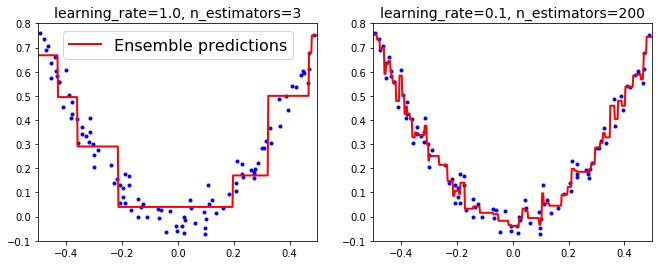

In [7]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.show()

通过上图可知，左侧训练集的树数量不足，右侧拟合训练集的树数量过多而导致过度拟合。

### [sklearn.ensemble.GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

### [sklearn.ensemble.GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

**Gradient Boosting with Early stopping**

下面我们通过**早期停止法**来寻找树的最佳数量，简单的实现方法就是使用 **staged_predict() 方法：在训练的每个阶段都会对集成的预测返回一个迭代器。**

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
min_error = np.min(errors)

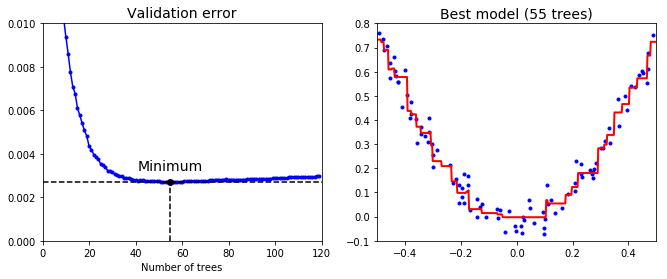

In [11]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

实际上，要实现早期停止法，不一定需要预先训练大量的树，然后回头找最优的数量，可以真的实现提前停止训练。设置 warm_state = True, 当 fit() 方法被调用时，sklearn 会保留现有的树，从而允许增量训练。以下代码会在验证误差连续5次迭代未改善时，直接停止训练。

In [12]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [13]:
print gbrt.n_estimators
print "Minimum validation MSE:", min_val_error 

61
Minimum validation MSE: 0.00271285332524


注：梯度提升分类和回归都支持超参数 subsample，指定用于训练每棵树的实例的比例。**这种做法用更高的偏差换取了更低的方差，同时相当大程度上加速了训练过程。称之为随机梯度提升。**

### [调参建议](https://jokerandjozee.com/2018/04/04/gradient-boosting-machinegbm/)

### XGBoost and LightGBM(待补充)

以下内容参考自论文：
1. [XGBoost](https://arxiv.org/pdf/1603.02754.pdf)
2. [LightGBM](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf)

## 堆叠法(stacking)

它基于一个简单的想法：相比之前的集成，都是通过一些简单的函数（平均法、投票法）来综合各个集成的结果得到最终输出。现在的做法是，**以各个集成的输出作为输入，训练一个模型（可以是一个学习器也可以是另外一个集成，我觉得这个有点神经网络的思路在里面了）来执行这个过程。**

上述的介绍是加了一层模型来对输出进行训练，实际上还可以在第二层模型之上再加一层模型来进行训练，这也就是“堆叠”的含义。

以最简单的堆叠法为例，也就是只加一层模型。训练混合器常用方法是留存法：

1. 将训练集 $D$ 分为两个不相交子集$D = D_1 \cup D_2$，$D_1$ 用来训练第一层的集成 $C_1$(假设有M个基学习器)；
2. 将训练好的$C_1$在 $D_2$ 上进行预测，得到预测值集合 $Y_{D_2}$(因为预测器在训练时没有见过这些实例，所以预测是“干净的”)；
3. 以 $Y_{D_2}$ 和 $D_2$ 中样本的真实目标值结合创建新的训练集 $\hat{D}$，其规模为：

$$|\hat{D}|=|Y_{D_2}|\cdot M$$

4. 在 $\hat{D}$ 上训练一个新的模型，将其输出作为最终的预测输出。

## Boosting 算法的特性

Boosting 算法在每一轮的训练过程中：
1. 对于可以接受带权样本的基学习算法，通过**“重赋权法”**实施，对样本重新赋予一个权重；
2. 对无法接受带权样本的基学习算法，则可以通过**“重采样法”**来处理，即根据样本分布对训练集重新采样，再用重采样而得的样本集对基学习器进行训练。

值得注意的是，Boosting 算法在每一轮都要检查当前的基学习器是否好于随机猜测（准确率大于0.5），如果不满足则丢弃当前的基学习器，并且学习过程停止。此种情形下，初始设置的学习轮数 T 也许远未达到，可能导致集成性能不佳。


**若采用“重采样法”，则可以获得“重启动”的机会来避免训练过程过早停止，即抛弃当前的基学习器，根据当前分布对训练集重新采样，基于新的采样结果重新训练出基学习器，使得学习过程可以持续。**

从偏差-方差角度看，Boosting 族算法主要关注降低偏差，增加被错误识别样本的权重来降低偏差，因此 Boosting 算法能基于泛化性能相当弱的学习器构建出很强的集成。